In [64]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
DATA_DIR = "../../data/"

In [66]:
data=pd.read_csv(DATA_DIR + 'new/cleaned_data.csv', parse_dates=['timestamp'])
data.head()

,timestamp,valence,arousal,emotion,heart_rate,stress,respiration,body_battery,spo2,sleep_score,hrv_avg,sleep_score_tier,time_of_day
0,2025-02-24 17:32:00,0.89,0.54,Happy,54.0,10.0,15.0,45.0,95.0,89.0,106.0,Good,Afternoon
1,2025-02-24 18:12:00,0.99,0.50,Happy,73.0,22.0,11.0,45.0,95.0,89.0,106.0,Good,Afternoon
2,2025-02-24 19:04:00,0.98,0.55,Happy,81.0,-1.0,-1.0,45.0,94.0,89.0,106.0,Good,Evening
3,2025-02-25 12:12:00,0.03,-0.04,Neutral,74.0,-1.0,-1.0,100.0,96.0,88.0,87.0,Good,Morning
4,2025-02-25 12:36:00,-0.87,0.64,Angry,110.0,-2.0,-1.0,100.0,96.0,88.0,87.0,Good,Morning


In [67]:
# Load the full dataset with all timestamps
merged_data = pd.read_csv(DATA_DIR + 'processed/garmin_data.csv')
merged_data.head()


,timestamp,heart_rate,stress,respiration,body_battery,spo2,sleep_score,hrv_avg,local_time
0,2025-04-21 23:00:00Z,54.0,17.0,NaN,21.0,95.0,96.0,84.0,2025-04-22 01:00:00
1,2025-04-21 23:02:00Z,53.0,17.0,12.0,21.0,95.0,96.0,84.0,2025-04-22 01:02:00
2,2025-04-21 23:04:00Z,54.0,17.0,12.0,21.0,95.0,96.0,84.0,2025-04-22 01:04:00
3,2025-04-21 23:06:00Z,59.0,17.0,15.0,21.0,95.0,96.0,84.0,2025-04-22 01:06:00
4,2025-04-21 23:08:00Z,52.0,17.0,15.0,21.0,95.0,96.0,84.0,2025-04-22 01:08:00


In [68]:
merged_data.columns

Index(['timestamp', 'heart_rate', 'stress', 'respiration', 'body_battery',
       'spo2', 'sleep_score', 'hrv_avg', 'local_time'],
      dtype='object')

In [69]:
# First convert both timestamps to datetime
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'])
merged_data['local_time'] = pd.to_datetime(merged_data['local_time'])

# Now do the renaming
merged_data = merged_data.drop(columns=['timestamp'])
merged_data = merged_data.rename(columns={'local_time': 'timestamp'})

# Set index and create lag features
merged_data.set_index('timestamp', inplace=True)
lag_features = pd.DataFrame(index=merged_data.index)
lag_features['hr_1'] = merged_data['heart_rate'].shift(1)  # 2 minutes ago
lag_features['hr_2'] = merged_data['heart_rate'].shift(2)  # 4 minutes ago
lag_features.reset_index(inplace=True)

# Make sure data's timestamp is also datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Now merge
data = pd.merge(
    data,
    lag_features,
    on='timestamp',
    how='left'
)

In [70]:
##make change in heartrate_now min and change in heart rate 2 min ago
data['hr_change_now'] = data['heart_rate'] - data['hr_1']
data['hr_change_2min'] = data['hr_2'] - data['hr_1']

data.head()

,timestamp,valence,arousal,emotion,heart_rate,stress,respiration,body_battery,spo2,sleep_score,hrv_avg,sleep_score_tier,time_of_day,hr_1,hr_2,hr_change_now,hr_change_2min
0,2025-02-24 17:32:00,0.89,0.54,Happy,54.0,10.0,15.0,45.0,95.0,89.0,106.0,Good,Afternoon,56.0,61.0,-2.0,5.0
1,2025-02-24 18:12:00,0.99,0.50,Happy,73.0,22.0,11.0,45.0,95.0,89.0,106.0,Good,Afternoon,84.0,75.0,-11.0,-9.0
2,2025-02-24 19:04:00,0.98,0.55,Happy,81.0,-1.0,-1.0,45.0,94.0,89.0,106.0,Good,Evening,84.0,90.0,-3.0,6.0
3,2025-02-25 12:12:00,0.03,-0.04,Neutral,74.0,-1.0,-1.0,100.0,96.0,88.0,87.0,Good,Morning,61.0,55.0,13.0,-6.0
4,2025-02-25 12:36:00,-0.87,0.64,Angry,110.0,-2.0,-1.0,100.0,96.0,88.0,87.0,Good,Morning,109.0,102.0,1.0,-7.0


In [71]:
# One-hot encode sleep_score_tier and time_of_day
sleep_score_dummies = pd.get_dummies(data['sleep_score_tier'], prefix='sleep_tier')
time_of_day_dummies = pd.get_dummies(data['time_of_day'], prefix='time')

# Drop the original categorical columns
data = data.drop(['sleep_score_tier', 'time_of_day'], axis=1)

##turn into int instead of true/false
sleep_score_dummies = sleep_score_dummies.astype(int)
time_of_day_dummies = time_of_day_dummies.astype(int)

# Concatenate the one-hot encoded columns
data = pd.concat([data, sleep_score_dummies, time_of_day_dummies], axis=1)

# Display the first few rows to verify the encoding
print("First few rows with encoded categorical variables:")
data.head()

First few rows with encoded categorical variables:


,timestamp,valence,arousal,emotion,heart_rate,stress,respiration,body_battery,spo2,sleep_score,...,hr_change_now,hr_change_2min,sleep_tier_Excellent,sleep_tier_Fair,sleep_tier_Good,sleep_tier_Poor,time_Afternoon,time_Evening,time_Morning,time_Night
0,2025-02-24 17:32:00,0.89,0.54,Happy,54.0,10.0,15.0,45.0,95.0,89.0,...,-2.0,5.0,0,0,1,0,1,0,0,0
1,2025-02-24 18:12:00,0.99,0.50,Happy,73.0,22.0,11.0,45.0,95.0,89.0,...,-11.0,-9.0,0,0,1,0,1,0,0,0
2,2025-02-24 19:04:00,0.98,0.55,Happy,81.0,-1.0,-1.0,45.0,94.0,89.0,...,-3.0,6.0,0,0,1,0,0,1,0,0
3,2025-02-25 12:12:00,0.03,-0.04,Neutral,74.0,-1.0,-1.0,100.0,96.0,88.0,...,13.0,-6.0,0,0,1,0,0,0,1,0
4,2025-02-25 12:36:00,-0.87,0.64,Angry,110.0,-2.0,-1.0,100.0,96.0,88.0,...,1.0,-7.0,0,0,1,0,0,0,1,0


In [72]:
# drop missing values
data = data.dropna()

print(data.isna().sum())


timestamp               0
valence                 0
arousal                 0
emotion                 0
heart_rate              0
stress                  0
respiration             0
body_battery            0
spo2                    0
sleep_score             0
hrv_avg                 0
hr_1                    0
hr_2                    0
hr_change_now           0
hr_change_2min          0
sleep_tier_Excellent    0
sleep_tier_Fair         0
sleep_tier_Good         0
sleep_tier_Poor         0
time_Afternoon          0
time_Evening            0
time_Morning            0
time_Night              0
dtype: int64


# MAKE DATASETS

In [73]:
def create_datasets(df):
    """Create separate datasets for valence, arousal, and emotion labels"""
    # Get physiological features
    physiological_cols = ['heart_rate', 'stress', 'respiration', 'body_battery', 'spo2', 'hrv_avg', 'sleep_score', 'hr_change_now', 'hr_change_2min']
    dummy_cols = ['time_Morning', 'time_Afternoon', 'time_Evening', 'time_Night']
    available_cols = [col for col in physiological_cols if col in df.columns]
    available_cols.extend(dummy_cols)
    
    # Create base features DataFrame
    features = df[['timestamp'] + available_cols].copy()
    
    # Create valence dataset
    valence_data = features.copy()
    valence_data['valence'] = df['valence']
    valence_data = valence_data.dropna(subset=['valence'])
    print(f"Valence dataset shape: {valence_data.shape}")
    
    # Create arousal dataset
    arousal_data = features.copy()
    arousal_data['arousal'] = df['arousal']
    arousal_data = arousal_data.dropna(subset=['arousal'])
    print(f"Arousal dataset shape: {arousal_data.shape}")
    
    # Create emotion labels dataset
    emotion_data = features.copy()
    emotion_data['emotion'] = df['emotion']
    emotion_data = emotion_data.dropna(subset=['emotion'])
    print(f"Emotion dataset shape: {emotion_data.shape}")
    
    # Save datasets
    valence_data.to_csv(DATA_DIR + 'clean/valence_dataset.csv', index=False)
    arousal_data.to_csv(DATA_DIR + 'clean/arousal_dataset.csv', index=False)
    emotion_data.to_csv(DATA_DIR + 'clean/emotion_dataset.csv', index=False)
    
    # Print the head
    print(display(valence_data.head()))
    print(display(arousal_data.head()))
    print(display(emotion_data.head()))
    
    return valence_data, arousal_data, emotion_data


valence_data, arousal_data, emotion_data = create_datasets(data)

Valence dataset shape: (143, 15)
Arousal dataset shape: (143, 15)
Emotion dataset shape: (143, 15)


,timestamp,heart_rate,stress,respiration,body_battery,spo2,hrv_avg,sleep_score,hr_change_now,hr_change_2min,time_Morning,time_Afternoon,time_Evening,time_Night,valence
0,2025-02-24 17:32:00,54.0,10.0,15.0,45.0,95.0,106.0,89.0,-2.0,5.0,0,1,0,0,0.89
1,2025-02-24 18:12:00,73.0,22.0,11.0,45.0,95.0,106.0,89.0,-11.0,-9.0,0,1,0,0,0.99
2,2025-02-24 19:04:00,81.0,-1.0,-1.0,45.0,94.0,106.0,89.0,-3.0,6.0,0,0,1,0,0.98
3,2025-02-25 12:12:00,74.0,-1.0,-1.0,100.0,96.0,87.0,88.0,13.0,-6.0,1,0,0,0,0.03
4,2025-02-25 12:36:00,110.0,-2.0,-1.0,100.0,96.0,87.0,88.0,1.0,-7.0,1,0,0,0,-0.87


None


,timestamp,heart_rate,stress,respiration,body_battery,spo2,hrv_avg,sleep_score,hr_change_now,hr_change_2min,time_Morning,time_Afternoon,time_Evening,time_Night,arousal
0,2025-02-24 17:32:00,54.0,10.0,15.0,45.0,95.0,106.0,89.0,-2.0,5.0,0,1,0,0,0.54
1,2025-02-24 18:12:00,73.0,22.0,11.0,45.0,95.0,106.0,89.0,-11.0,-9.0,0,1,0,0,0.50
2,2025-02-24 19:04:00,81.0,-1.0,-1.0,45.0,94.0,106.0,89.0,-3.0,6.0,0,0,1,0,0.55
3,2025-02-25 12:12:00,74.0,-1.0,-1.0,100.0,96.0,87.0,88.0,13.0,-6.0,1,0,0,0,-0.04
4,2025-02-25 12:36:00,110.0,-2.0,-1.0,100.0,96.0,87.0,88.0,1.0,-7.0,1,0,0,0,0.64


None


,timestamp,heart_rate,stress,respiration,body_battery,spo2,hrv_avg,sleep_score,hr_change_now,hr_change_2min,time_Morning,time_Afternoon,time_Evening,time_Night,emotion
0,2025-02-24 17:32:00,54.0,10.0,15.0,45.0,95.0,106.0,89.0,-2.0,5.0,0,1,0,0,Happy
1,2025-02-24 18:12:00,73.0,22.0,11.0,45.0,95.0,106.0,89.0,-11.0,-9.0,0,1,0,0,Happy
2,2025-02-24 19:04:00,81.0,-1.0,-1.0,45.0,94.0,106.0,89.0,-3.0,6.0,0,0,1,0,Happy
3,2025-02-25 12:12:00,74.0,-1.0,-1.0,100.0,96.0,87.0,88.0,13.0,-6.0,1,0,0,0,Neutral
4,2025-02-25 12:36:00,110.0,-2.0,-1.0,100.0,96.0,87.0,88.0,1.0,-7.0,1,0,0,0,Angry


None


## Valence

In [74]:
#Overall description of valence
# print(valence_data.info())

#Count missing values
print(valence_data.isnull().sum())


timestamp         0
heart_rate        0
stress            0
respiration       0
body_battery      0
spo2              0
hrv_avg           0
sleep_score       0
hr_change_now     0
hr_change_2min    0
time_Morning      0
time_Afternoon    0
time_Evening      0
time_Night        0
valence           0
dtype: int64


Valence Statistics:
count    143.000000
mean       0.110699
std        0.590866
min       -1.050000
25%       -0.315000
50%        0.050000
75%        0.650000
max        1.190000
Name: valence, dtype: float64


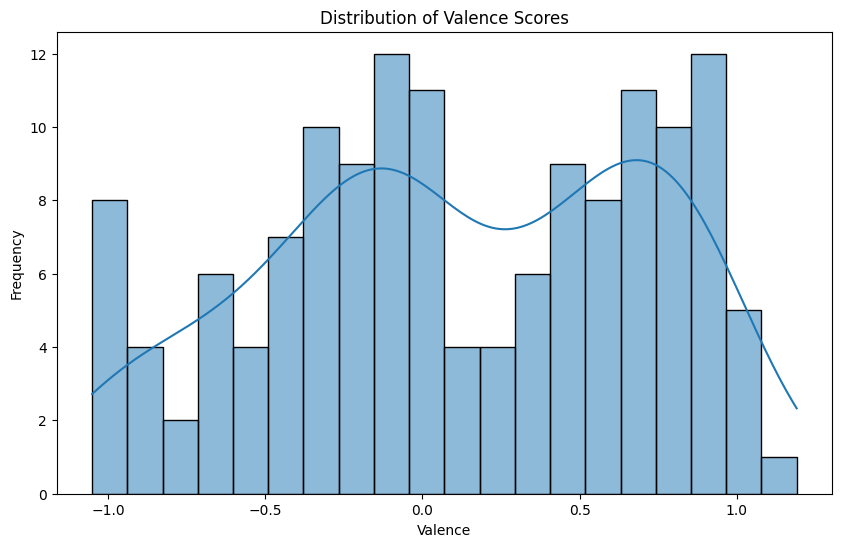

In [75]:
# Basic statistics for valence
valence_stats = valence_data['valence'].describe()
print("Valence Statistics:")
print(valence_stats)

# Plot the distribution of valence scores
plt.figure(figsize=(10, 6))
sns.histplot(data=valence_data, x='valence', bins=20, kde=True)
plt.title('Distribution of Valence Scores')
plt.xlabel('Valence')
plt.ylabel('Frequency')
plt.savefig('../../plots/valence_freq.png', dpi=300, bbox_inches='tight')
plt.show()


Correlations with Valence:
valence           1.000000
heart_rate        0.098525
sleep_score       0.071325
body_battery      0.067683
time_Evening      0.046358
time_Morning      0.038990
hrv_avg           0.009199
stress            0.006090
spo2              0.004445
time_Afternoon   -0.009119
hr_change_2min   -0.010295
respiration      -0.076969
hr_change_now    -0.098050
time_Night       -0.149528
Name: valence, dtype: float64


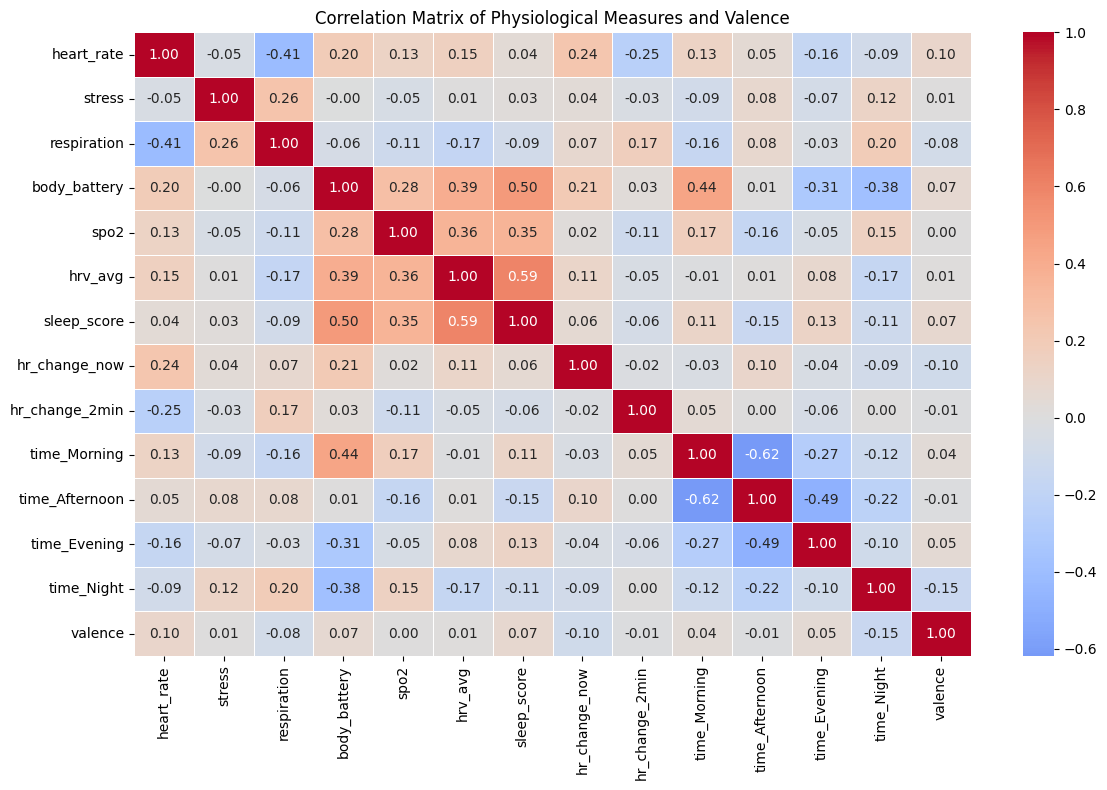

In [76]:
correlation_matrix = valence_data.drop(columns=['timestamp']).corr()
# Print correlation values with valence
print("\nCorrelations with Valence:")
print(correlation_matrix['valence'].sort_values(ascending=False))

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f',
            linewidths=0.5)
plt.title('Correlation Matrix of Physiological Measures and Valence')
plt.tight_layout()

# Save the plot
plt.savefig('../../plots/valence_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [78]:
#
columns_to_drop = ['timestamp', 'stress','hrv_avg', 'spo2', 'hr_change_2min', 'time_Afternoon']

#drop columns and do correlation matrix
correlation_matrix = valence_data.drop(columns=columns_to_drop).corr()
# Print correlation values with valence
print("\nCorrelations with Valence:")
print(correlation_matrix['valence'].sort_values(ascending=False))



Correlations with Valence:
valence          1.000000
heart_rate       0.098525
sleep_score      0.071325
body_battery     0.067683
time_Evening     0.046358
time_Morning     0.038990
respiration     -0.076969
hr_change_now   -0.098050
time_Night      -0.149528
Name: valence, dtype: float64


In [79]:
#save as valence_cleaned
valence_cleaned = valence_data.drop(columns=columns_to_drop)
valence_cleaned.to_csv(DATA_DIR + 'final/valence_final.csv', index=False)

## Arousal

Arousal Statistics:
count    143.000000
mean       0.176853
std        0.549036
min       -1.120000
25%       -0.260000
50%        0.340000
75%        0.585000
max        1.070000
Name: arousal, dtype: float64


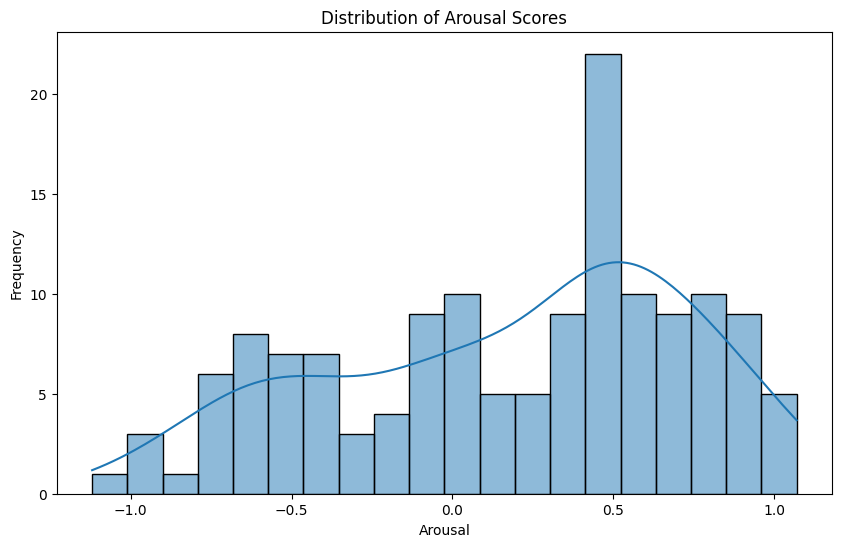

In [80]:
# Basic statistics for valence
arousal_stats = arousal_data['arousal'].describe()
print("Arousal Statistics:")
print(arousal_stats)

# Plot the distribution of valence scores
plt.figure(figsize=(10, 6))
sns.histplot(data=arousal_data, x='arousal', bins=20, kde=True)
plt.title('Distribution of Arousal Scores')
plt.xlabel('Arousal')
plt.ylabel('Frequency')
plt.savefig('../../plots/arousal_freq.png', dpi=300, bbox_inches='tight')
plt.show()


Correlations with Arousal:
arousal           1.000000
hr_change_now     0.258694
heart_rate        0.236808
spo2              0.162270
hrv_avg           0.103380
time_Afternoon    0.092958
body_battery      0.053223
stress            0.047041
time_Night        0.019692
time_Evening     -0.034033
sleep_score      -0.039208
hr_change_2min   -0.082699
time_Morning     -0.086191
respiration      -0.087779
Name: arousal, dtype: float64


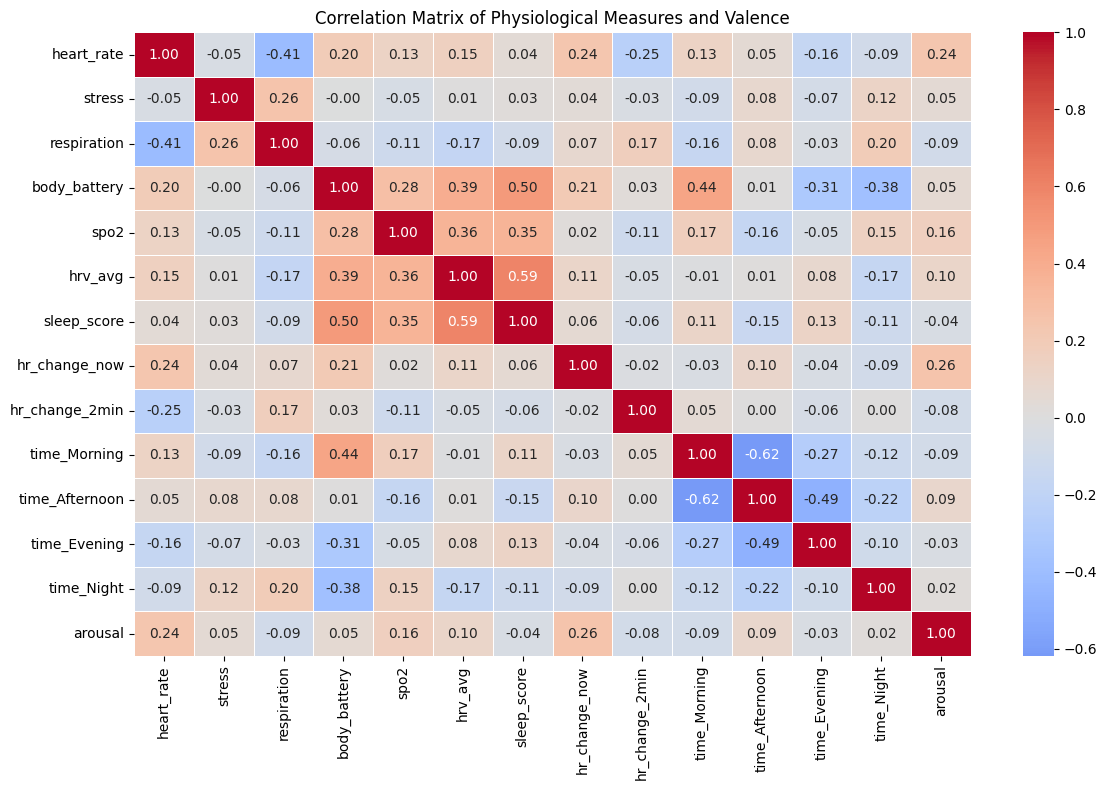

In [81]:
correlation_matrix = arousal_data.drop(columns=['timestamp']).corr()
# Print correlation values with valence
print("\nCorrelations with Arousal:")
print(correlation_matrix['arousal'].sort_values(ascending=False))

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f',
            linewidths=0.5)
plt.title('Correlation Matrix of Physiological Measures and Valence')
plt.tight_layout()

# Save the plot
plt.savefig('../../plots/arousal_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [82]:
#Drop columns with an absolute correlation below 6%
columns_to_drop = ['stress', 'body_battery', 'sleep_score', 'time_Evening', 'time_Night']

#drop columns and do correlation matrix
correlation_matrix = arousal_data.drop(columns=columns_to_drop).corr()
# Print correlation values with valence
print("\nCorrelations with Arousal:")
print(correlation_matrix['arousal'].sort_values(ascending=False))


Correlations with Arousal:
arousal           1.000000
hr_change_now     0.258694
heart_rate        0.236808
spo2              0.162270
hrv_avg           0.103380
time_Afternoon    0.092958
hr_change_2min   -0.082699
time_Morning     -0.086191
respiration      -0.087779
timestamp        -0.112368
Name: arousal, dtype: float64


In [83]:
## save as arousal_cleaned
arousal_cleaned = arousal_data.drop(columns=columns_to_drop)
arousal_cleaned.to_csv(DATA_DIR + 'final/arousal_final.csv', index=False)